## Задание

1) Exploratory data analysis: поискать интересные фичи, интересные корреляции, распределения,

2) Генерация новых признаков

3) Эксперименты с алгоритмами бустинга, изученными на лекции

4) Выбор лучшей модели 

5) Отправка на платформу kaggle и результат на тестовых данных (оттуда можно скачать test.csv, sample_submission.csv, в репозиторий не добавлял, чтобы не увеличивать объём).

https://www.kaggle.com/c/sberbank-russian-housing-market/data

Помогут выполнить задание слайды с лекции 2, а также 2 семинарских ноутбука

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv', parse_dates=['timestamp'])
data = data.set_index('id')

Ставится задача по всем признакам предсказать целевую переменную `price_doc`. Более подробнную информацию о признаках можно найти в `data.txt`

In [3]:
data.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


### Обработка признаков 


Посмотрим, какие типы данных присутствуют в нашей выборке

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 1 to 30473
Columns: 291 entries, timestamp to price_doc
dtypes: datetime64[ns](1), float64(119), int64(156), object(15)
memory usage: 67.9+ MB


Посмотрим на корреляцию в данных

In [5]:
cols_X = data.select_dtypes([np.int,np.float]).columns

In [6]:
means = data[cols_X].mean()

In [7]:
np_corr = np.corrcoef(data[cols_X].fillna(means).T)

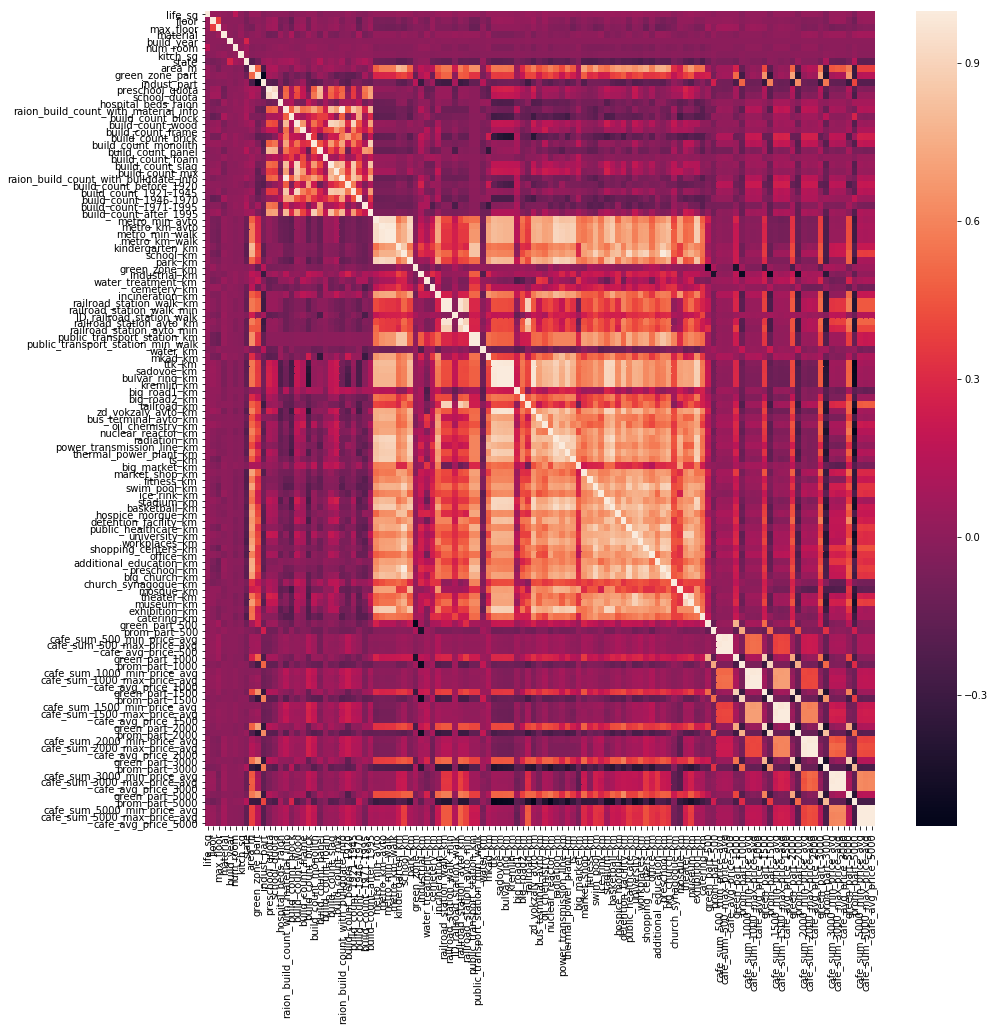

In [8]:
fig, ax = plt.subplots(figsize=(15,15)) 
g = sns.heatmap((np_corr), xticklabels=cols_X, ax=ax, yticklabels=cols_X)

#### Обработка временных признаков

Комбинированный признак, отвечающий за время мы можем разделить на год, месяц и день недели.

In [9]:
data['year'] = data['timestamp'].apply(lambda x: x.year)
data['month'] = data['timestamp'].apply(lambda x: x.month)
data['day'] = data['timestamp'].apply(lambda x: x.day_name())

In [10]:
from datetime import datetime as dt
from datetime import timedelta as td

In [11]:
# расстояние до праздников
holidays = [(1,1),(2,1),(3,1),(4,1),(5,1),(6,1),(7,1),
            (23,2),
            (8,3),
            (1,5),
            (9,5),
            (12,6),
            (4,11),
            (31,12)]

In [12]:
def holiday_distance(Series):
    diffs = []
    for holiday in holidays:
        date_string = '{}.{}.{}'.format(holiday[0], holiday[1], Series['year'])
        diffs.append(abs((dt.strptime(date_string,'%d.%m.%Y')-Series['timestamp'])/td(1)))
    return min(diffs)

In [13]:
data['next_holiday_distance'] = data.apply(holiday_distance,axis=1)

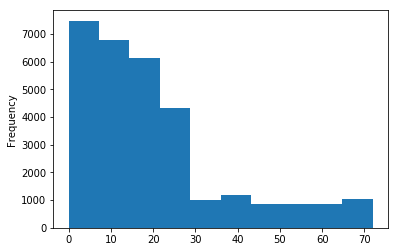

In [14]:
data['next_holiday_distance'].plot.hist()

In [15]:
data = data.drop('timestamp', axis=1)

In [16]:
ddf = data.dtypes.reset_index()
ddf.columns = ['cols', 'Type']
ddf.groupby('Type').count()

,cols
Type,
int64,158
float64,120
object,16


### Обработка категориальных значений

In [17]:
ddf = data.dtypes.reset_index()
ddf.columns = ['cols', 'Type']

Категориальные признаки как правило имеют тип `'object'`. Поэтому достанем их и посмотрим глазами на них

In [18]:
cat_bin_columns = ddf[ddf.Type == 'object'].cols.values

In [19]:
cat_bin_columns

array(['product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion',
       'railroad_terminal_raion', 'big_market_raion',
       'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line',
       'big_road1_1line', 'railroad_1line', 'ecology', 'day'],
      dtype=object)

In [20]:
data[cat_bin_columns].head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology,day
id,,,,,,,,,,,,,,,,
1,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good,Saturday
2,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent,Tuesday
3,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor,Saturday
4,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good,Thursday
5,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent,Monday


In [21]:
!pip install --user scikit-learn==0.21.2

In [22]:
cat_columns = ['product_type', 'sub_area', 'ecology', 'day']
bin_columns = list(set(cat_bin_columns) - set(cat_columns))

Бинарные признаки обработаем с помощью OrdinalEncoder

In [23]:
from sklearn.preprocessing import OrdinalEncoder

In [24]:
lbl = OrdinalEncoder()
lbl.fit(data[bin_columns])
data[bin_columns] = lbl.transform(data[bin_columns])

In [25]:
data[bin_columns].head()

,oil_chemistry_raion,water_1line,railroad_terminal_raion,thermal_power_plant_raion,incineration_raion,detention_facility_raion,culture_objects_top_25,big_road1_1line,railroad_1line,nuclear_reactor_raion,radiation_raion,big_market_raion
id,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [26]:
ddf = data.dtypes.reset_index()
ddf.columns = ['Count columns', 'Type']
ddf.groupby('Type').count()

,Count columns
Type,
int64,158
float64,132
object,4


In [27]:
def gen_features(df,col_1,col_2):
    opers = ['+','-']
    for oper in opers:
        df[col_1+oper+col_2] = eval('df[col_1]'+oper+'df[col_2]')
        if oper == '/':
            inf_mask = np.isinf(df[col_1+oper+col_2])
            if inf_mask.any():
                df.at[inf_mask,col_1+oper+col_2] = np.nan
    return df    

In [28]:
numeric = data.select_dtypes([np.int64,np.float]).columns
len(numeric)

290

In [29]:
rand1 = np.random.RandomState(15)
rand2 = np.random.RandomState(16)

In [30]:
numeric_random_1 = rand1.permutation(numeric)
numeric_random_2 = rand2.permutation(numeric)

In [31]:
col_rand_1 = 10
col_rand_2 = 10

In [32]:
for col_1 in numeric_random_1[:col_rand_1]:
    for col_2 in numeric_random_2[:col_rand_2]:
        if col_1!=col_2:
            data = gen_features(data,col_1,col_2)
            
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 1 to 30473
Columns: 494 entries, full_sq to office_count_2000-railroad_km
dtypes: float64(282), int64(208), object(4)
memory usage: 115.1+ MB


### Разделение выборки на Train и Test

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
for col in cat_columns:
    data[col] = data[col].astype('category')

In [35]:
train_data, test_data = train_test_split(data, test_size=0.3,
                                          shuffle=True,
                                          random_state=42)
train_data = train_data.copy()
test_data = test_data.copy()

In [36]:
y_train = train_data['price_doc']
X_train = train_data.drop('price_doc', axis=1)

y_test = test_data['price_doc']
X_test = test_data.drop('price_doc', axis=1)

In [37]:
import lightgbm as lgbm
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

In [38]:
n_estimators = 5000

In [39]:
r2_threshold = 0.05

In [40]:
lgbm_regr = lgbm.LGBMRegressor(colsample_bytree=0.7,n_estimators=n_estimators)

In [41]:
lgbm_regr.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [42]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error

rmsle = lambda y1, y2: np.sqrt(mean_squared_log_error(y1, y2))

In [43]:
pred_test = lgbm_regr.predict(X_test)
negative_mask = pred_test<0
pred_test[negative_mask] = 0

In [49]:
rmsle(y_test, pred_test)

0.5009965952423613

In [50]:
lgbm_regr.score(X_test, y_test)

0.6837354879909119

In [51]:
fillna_value = -9999999999
numeric2 = X_train.select_dtypes([np.int64,np.float]).columns
X_train.at[:, numeric2] = X_train[numeric2].fillna(fillna_value)
X_test.at[:, numeric2] = X_test[numeric2].fillna(fillna_value)
lgbm_regr.fit(X_train, y_train)
pred_test = lgbm_regr.predict(X_test)
negative_mask = pred_test<0
pred_test[negative_mask] = 0
rmsle(y_test, pred_test)
r2 = lgbm_regr.score(X_test, y_test)
print(rmsle, r2)

0.4748516250158271 0.6742229212384021


In [52]:
flag_numeric = True
perm = PermutationImportance(lgbm_regr, cv=3)

if flag_numeric:
    numeric2 = X_train.select_dtypes([np.int64,np.float]).columns
    perm.fit(X_train[numeric2], y_train)
else:
    perm.fit(X_train, y_train)
    
sel = SelectFromModel(perm, threshold=r2_threshold, prefit=True)

C:\Users\Anton\Anaconda3\lib\site-packages\pandas\core\series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
non_numeric = X_train.select_dtypes(exclude=[np.int64,np.float]).columns

In [ ]:
if flag_numeric:
    X_train = pd.concat([X_train[non_numeric], sel.transform(X_train[numeric2])], axis=1)
    X_test = pd.concat([X_test[non_numeric], sel.transform(X_test[numeric2])], axis=1)
else:
    X_train = sel.transform(X_train)
    X_test = sel.transform(X_test)
    
X_train.info()

In [ ]:
n_rounds = lgbm.cv(X_train,y_train,cv = 5)
len(n_rounds)

In [ ]:
# from hyperopt import hp, tpe, Trials, STATUS_OK
# from hyperopt.fmin import fmin
# from hyperopt import space_eval
# space = {
#     'reg_alpha': hp.quniform('reg_alpha',space_bo['reg_alpha'][0],space_bo['reg_alpha'][1]),
#     'num_leaves': hp.choice('num_leaves', ),
#     'colsample_bytree': hp.uniform('colsample_bytree',space_bo['colsample_bytree'][0],space_bo['colsample_bytree'][1]),
#     }


In [ ]:
from sklearn.model_selection import GridSearchCV

num_rounds = len(n_rounds)-1
model = lgbm.LGBMRegressor(n_estimators=num_rounds)

add_params = {'max_depth':[3, 8],
              'max_leaves':[10, 20, 30],
              'subsample':[0.3, 0.5, 0.7, 0.9]
             }
grid = GridSearchCV(model, add_params, n_jobs=2,verbose=2, cv=3)
grid.fit(X=X_train, y=y_train)

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
rmsle(y_test,grid.predict(X_test))

In [31]:
reg = Ridge(alpha=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred[y_pred<=0] = 1e-8
rmsle(y_test, y_pred)

0.5447315211461836

In [ ]:
# class PermutationImportance(BaseEstimator, MetaEstimatorMixin):
#     """
#     Parameters
#     ----------
#     estimator : object
#         The base estimator. This can be both a fitted
#         (if ``prefit`` is set to True) or a non-fitted estimator.

#     scoring : string, callable or None, default=None
#         Scoring function to use for computing feature importances.
#         A string with scoring name (see scikit-learn docs) or
#         a scorer callable object / function with signature
#         ``scorer(estimator, X, y)``.
#         If ``None``, the ``score`` method of the estimator is used.

#     n_iter : int, default 5
#         Number of random shuffle iterations. Decrease to improve speed,
#         increase to get more precise estimates.

#     random_state : integer or numpy.random.RandomState, optional
#         random state

#     cv : int, cross-validation generator, iterable or "prefit"
#         Determines the cross-validation splitting strategy.
#         Possible inputs for cv are:

#             - None, to disable cross-validation and compute feature importances
#               on the same data as used for training.
#             - integer, to specify the number of folds.
#             - An object to be used as a cross-validation generator.
#             - An iterable yielding train/test splits.
#             - "prefit" string constant (default).

#         If "prefit" is passed, it is assumed that ``estimator`` has been
#         fitted already and all data is used for computing feature importances.

#     refit : bool
#         Whether to fit the estimator on the whole data if cross-validation
#         is used (default is True).

#     Attributes
#     ----------
#     feature_importances_ : array
#         Feature importances, computed as mean decrease of the score when
#         a feature is permuted (i.e. becomes noise).

#     feature_importances_std_ : array
#         Standard deviations of feature importances.

#     results_ : list of arrays
#         A list of score decreases for all experiments.

#     scores_ : array of float
#         A list of base scores for all experiments (with no features permuted).

#     estimator_ : an estimator
#         The base estimator from which the :class:`~PermutationImportance`
#         instance  is built. This is stored only when a non-fitted estimator
#         is passed to the :class:`~PermutationImportance`, i.e when ``cv`` is
#         not "prefit".

#     rng_ : numpy.random.RandomState
#         random state
#     """
#     def __init__(self, estimator, scoring=None, n_iter=5, random_state=None,
#                  cv='prefit', refit=True):
#         # type: (...) -> None
#         if isinstance(cv, str) and cv != "prefit":
#             raise ValueError("Invalid cv value: {!r}".format(cv))
#         self.refit = refit
#         self.estimator = estimator
#         self.scoring = scoring
#         self.n_iter = n_iter
#         self.random_state = random_state
#         self.cv = cv
#         self.rng_ = check_random_state(random_state)